In [1]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

Using TensorFlow backend.


# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_12
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096

random.seed()

## Load the pre-processed training file. The training file already contains the anchors and cluster information.


In [3]:
INPUT_FILE_PATH = './input/labels_train_full'

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))



### Statistics about the breeds in dataset

In [4]:
display(df_train.groupby(['breed']).agg(['count']))

,id,encoding,anp,cluster
,count,count,count,count
breed,,,,
affenpinscher,64,64,64,64
afghan_hound,92,92,92,92
african_hunting_dog,68,68,68,68
airedale,85,85,85,85
american_staffordshire_terrier,59,59,59,59
appenzeller,62,62,62,62
australian_terrier,81,81,81,81
basenji,88,88,88,88


### Breeds and sample of pictures

'total number of breeds 120'

chow


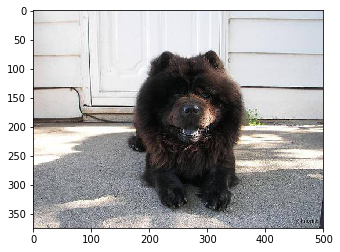

komondor


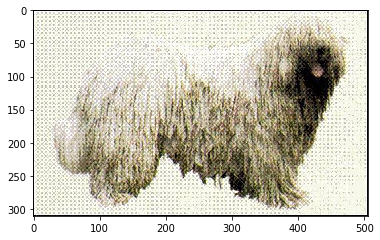

In [5]:
breeds = df_train['breed'].unique()

display('total number of breeds ' + str(len(breeds)))


def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)

    
def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()

    
sample_by_breed(df_train)
sample_by_breed(df_train)

## Load the pre-processed triplets training file
## Shuffle the triplets so that we don't just train all of a single breed first 

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

df_triplets = shuffle_triplets(df_triplets)
display('Total number of triplets ' + str(df_triplets.shape[0]))

display(df_triplets.head())

'Total number of triplets 11605356'

,anchor_id,anchor_type,anchor_encoding,positive_id,positive_type,positive_encoding,negative_id,negative_type,negative_encoding
0,518c87979c25cbc26b27b459e52a6335,irish_terrier,./input/vgg19_4096/518c87979c25cbc26b27b459e52...,156e74a393c76b215752d692eccd9135,irish_terrier,./input/vgg19_4096/156e74a393c76b215752d692ecc...,a409d83b4e22c12c931b6cf1544e0310,shih-tzu,./input/vgg19_4096/a409d83b4e22c12c931b6cf1544...
1,302b9eaf28568bdc9367411b52899b93,gordon_setter,./input/vgg19_4096/302b9eaf28568bdc9367411b528...,8f9f48b4ad92e8f3082d2ab40d9f5e51,gordon_setter,./input/vgg19_4096/8f9f48b4ad92e8f3082d2ab40d9...,37b5d37070d1d054d1879e923775a1a9,bedlington_terrier,./input/vgg19_4096/37b5d37070d1d054d1879e92377...
2,202d6a18246367a631ae85ad77727df4,great_pyrenees,./input/vgg19_4096/202d6a18246367a631ae85ad777...,7d275bed18ce83cf13a8fcdb9c266d4d,great_pyrenees,./input/vgg19_4096/7d275bed18ce83cf13a8fcdb9c2...,458e3d94b7a0e21c8da7796139f065d0,japanese_spaniel,./input/vgg19_4096/458e3d94b7a0e21c8da7796139f...
3,454aef984f2a2e3416aae8277b6b2422,beagle,./input/vgg19_4096/454aef984f2a2e3416aae8277b6...,5b903adeb4c923ba3046929c7062927a,beagle,./input/vgg19_4096/5b903adeb4c923ba3046929c706...,7b34e1fd489cdb9bf1a2c34a1b847278,dingo,./input/vgg19_4096/7b34e1fd489cdb9bf1a2c34a1b8...
4,2febdc2d2ada6a4a8b5bcfddc36fe8ad,greater_swiss_mountain_dog,./input/vgg19_4096/2febdc2d2ada6a4a8b5bcfddc36...,5683181d8388c19f7ad6b08804506194,greater_swiss_mountain_dog,./input/vgg19_4096/5683181d8388c19f7ad6b088045...,c668cb4cfab62856f6520c4c3358fe08,west_highland_white_terrier,./input/vgg19_4096/c668cb4cfab62856f6520c4c335...


### Show samples of the triplets

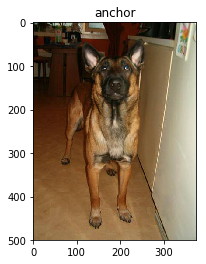

./input/train-2/4d98705d155671039f3b45f96eb73a63.jpg
malinois


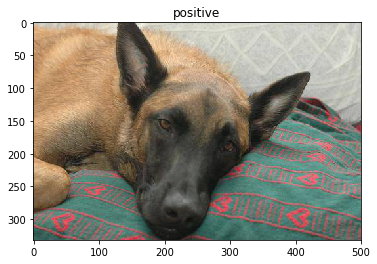

./input/train-2/63d413f73e1e8de516fce933245277d7.jpg
malinois


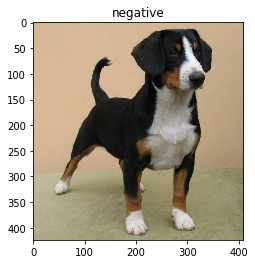

./input/train-2/9a303c60ced446a367364eeb122eea3c.jpg
entlebucher


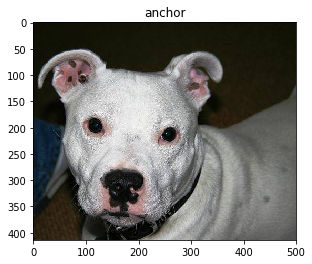

./input/train-2/193341cdba32aaace0609a1d633e3f33.jpg
american_staffordshire_terrier


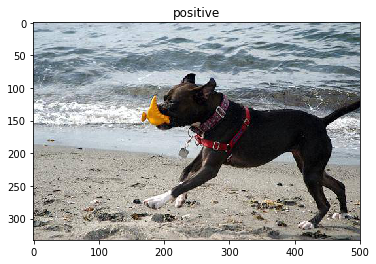

./input/train-2/83bcff6b55ee179a7c123fa6103c377a.jpg
american_staffordshire_terrier


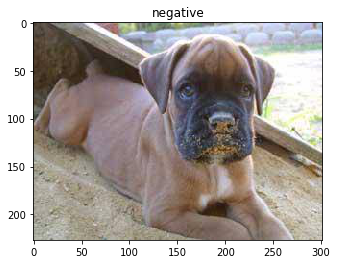

./input/train-2/70d889ecc5ab471c8ef59c5a110b705e.jpg
boxer


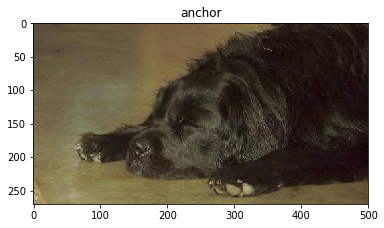

./input/train-2/a420274ff9508fa213b15344d19122b0.jpg
newfoundland


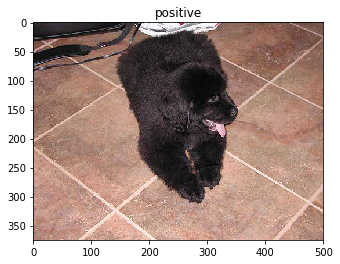

./input/train-2/28b0c66727c333afe43cb7c6006cd3a0.jpg
newfoundland


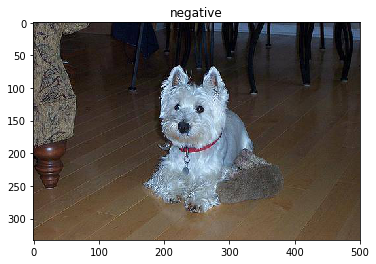

./input/train-2/0a70f64352edfef4c82c22015f0e3a20.jpg
west_highland_white_terrier


In [7]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


In [ ]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001

def load_triplets(df_triplets):
    n_triplets = df_triplets.shape[0]
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    for ri, triplet in df_triplets.iterrows():
        anchors[i] = np.loadtxt(triplet['anchor_encoding'])
        pos[i] = np.loadtxt(triplet['positive_encoding'])
        negs[i] = np.loadtxt(triplet['negative_encoding'])
        i = i + 1
    return anchors, pos, negs



### Load the encoding for the given triplets into memory
### Train the model with the whole training set

because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies


In [ ]:

def generator(df_labels, batch_size):
    n_triplets = batch_size
    s = 0
    while True:
        e = s + n_triplets
        df_triplets = df_labels.iloc[s:e]
        y_dummies = np.zeros((n_triplets, 1, n_triplets))
        anchors, pos, negs = load_triplets(df_triplets)
        s = s + n_triplets
        yield [anchors, pos, negs], [y_dummies, y_dummies, y_dummies]

batch_size = 3072
steps_per_epoch = int(df_triplets.shape[0]/batch_size)
display('steps per epoch ' + str(steps_per_epoch))

training_model.fit_generator(generator=generator(df_triplets, batch_size=batch_size), epochs=1, steps_per_epoch=steps_per_epoch, shuffle=True, use_multiprocessing=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

'steps per epoch 11333'

Epoch 1/1
    1/11333 [..............................] - ETA: 156:56:38 - loss: 0.1984 - inputEncodingModel_loss_1: 7.2004e-05 - inputEncodingModel_loss_2: 0.0853 - inputEncodingModel_loss_3: 0.1130 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

In [ ]:
def triplet_tuple(id_value, breed_value, encoding_value):
    return [id_value, breed_value, encoding_value]

def create_triplet(anchor_tuple, positive_tuple, negative_tuple):
    result = []
    for value in anchor_tuple:
        result.append(value)
    for value in positive_tuple:
        result.append(value)
    for value in negative_tuple:
        result.append(value)
    return result

def extract_triplets(df_mismatch, df_train):
    new_triplets_list = []

    for i, bad_pred in df_mismatch.iterrows():
        pred_anchors = df_train.loc[(df_train.breed == bad_pred.breed)]
        for i, pred_anchor in pred_anchors.iterrows():
            anchor = triplet_tuple(pred_anchor['id'], pred_anchor['breed'], pred_anchor['encoding'])
            positive = triplet_tuple(bad_pred['id'], bad_pred['breed'], bad_pred['encoding'])
            negative = triplet_tuple(bad_pred['prediction_id'], bad_pred['prediction_breed'], bad_pred['prediction_encoding'])
            new_triplets_list.append(create_triplet(anchor, positive, negative))
#             new_triplets_list.append(create_triplet(positive, anchor, negative))

    df_new_triplets = pd.DataFrame(new_triplets_list, columns=['anchor_id', 'anchor_type', 'anchor_encoding', 'positive_id', 'positive_type', 'positive_encoding', 'negative_id', 'negative_type', 'negative_encoding'])
    return df_new_triplets

### Load the bad prediction and train the model to recognize these against the corresponding anchors

In [ ]:
df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
print(df_new_triplets.shape)
df_new_triplets.head()

anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=50, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
